In [1]:
import matplotlib.pyplot as plt
from ptoa.data.fastmri_dataset import FastSliceDataset
import pandas as pd
import numpy as np
from pathlib import Path
from models.network import Network
import torch
from glob import glob
from torch import nn
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

In [2]:
torch. set_grad_enabled(False)
l1 = nn.L1Loss()
l2 = nn.MSELoss()
kl = nn.KLDivLoss()
ce = nn.CrossEntropyLoss()
tx = T.ToTensor()
SMOOTH = 1

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:00,  3.47it/s]

train_colorization_fastmri_230815_115532 0.004581231623888016


 67%|██████▋   | 2/3 [00:01<00:01,  1.02s/it]

train_colorization_mooncomet_e4_quad_230821_172232 0.007358059752732515


100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


train_colorization_fastmri_230816_144807 0.004067413508892059


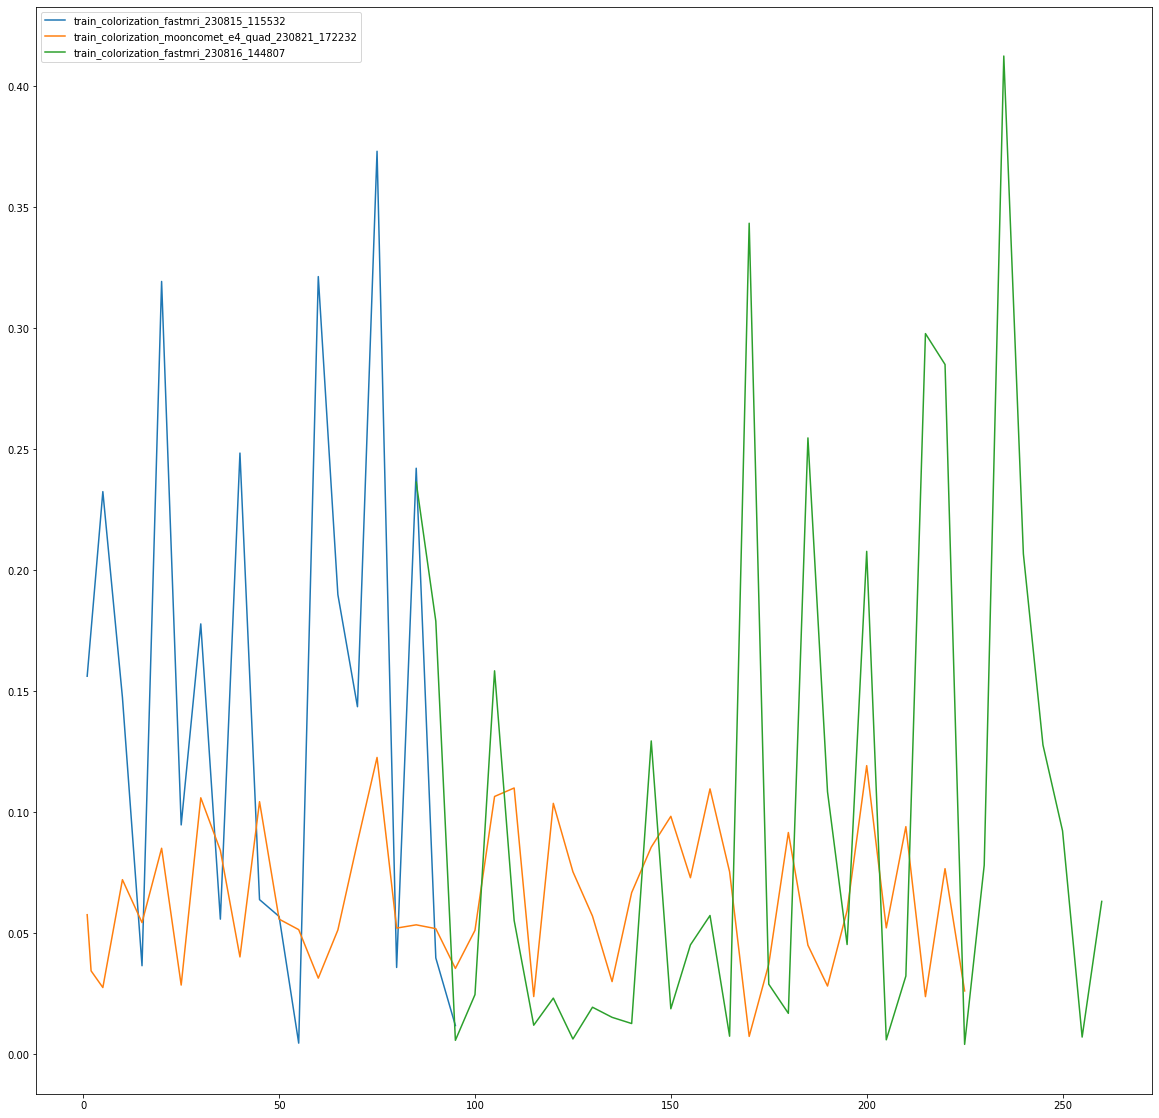

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*colorization*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=0):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0]} for k in slcs}
        l1_loss = []
        l2_loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            l1_loss.append(l1(out_array, gt_array))
            l2_loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'l1_loss': torch.tensor(l1_loss).mean(),
            'l2_loss': torch.tensor(l2_loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    ax.plot(ret.keys(), pd.Series([r['l2_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)
    if ret:
        print(experiment, min([r['l2_loss'] for r in ret.values()]).item())
    # plt.plot(ret.keys(), [r['l2_loss'] for r in ret.values()], label='l2_loss')
    # plt.title(experiment)
ax.legend()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


train_boneinpainting_fastmri_e4_quad_230822_203439 0.21293143928050995


 50%|█████     | 2/4 [00:07<00:07,  3.92s/it]

train_boneinpainting_fastmri_e4_quad_230822_211302 0.0012997506419196725


 75%|███████▌  | 3/4 [00:08<00:02,  2.66s/it]

train_boneinpainting_fastmri_e4_quad_230822_211310 0.004631813149899244


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


train_boneinpainting_fastmri_e4_quad_230822_211308 0.0025857288856059313


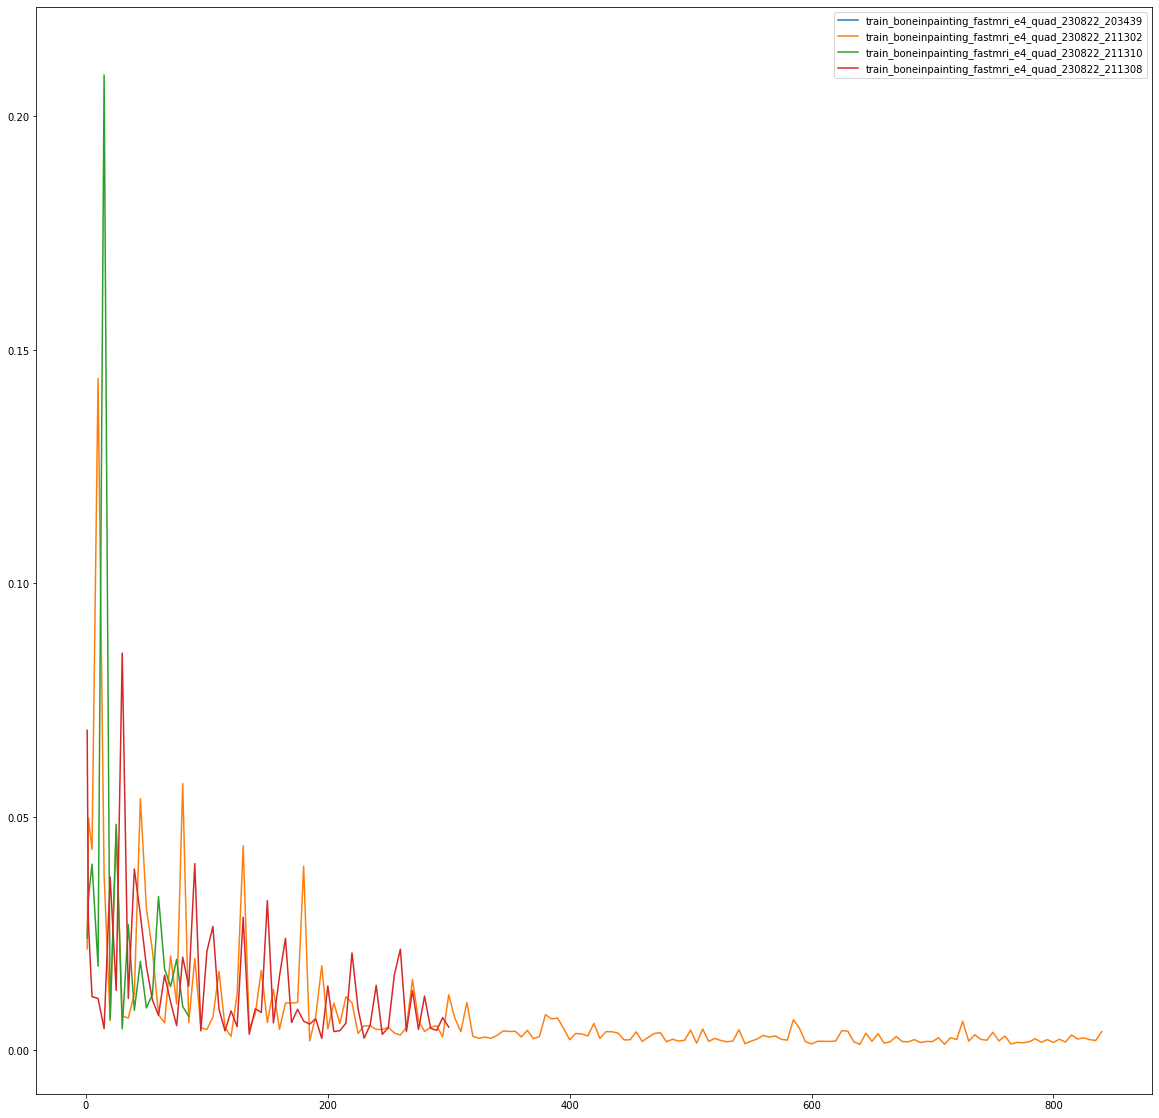

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*boneinpainting*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=1):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out', 'Mask'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','').replace('Mask_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0],
            'mask': [p for p in pngs if k in p and 'Mask' in p][0]} for k in slcs}
        masked_loss = []
        loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            mask_path = slc['mask']
            mask = Image.open(mask_path)
            mask_array = tx(mask) == 1
            masked_loss.append(torch.sum((gt_array - out_array) ** 2) / mask_array.sum())
            loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'masked_loss': torch.tensor(masked_loss).mean(),
            'loss': torch.tensor(loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    if [r['masked_loss'] for r in ret.values()]:
        ax.plot(ret.keys(), pd.Series([r['masked_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)

    if ret:
        print(experiment, min([r['masked_loss'] for r in ret.values()]).item())
ax.legend()
plt.show()

0it [00:00, ?it/s]/18 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 21.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 19/19 [00:00<00:00, 22.43it/s]
0it [00:00, ?it/s]2/18 [00:07<00:03,  1.67it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


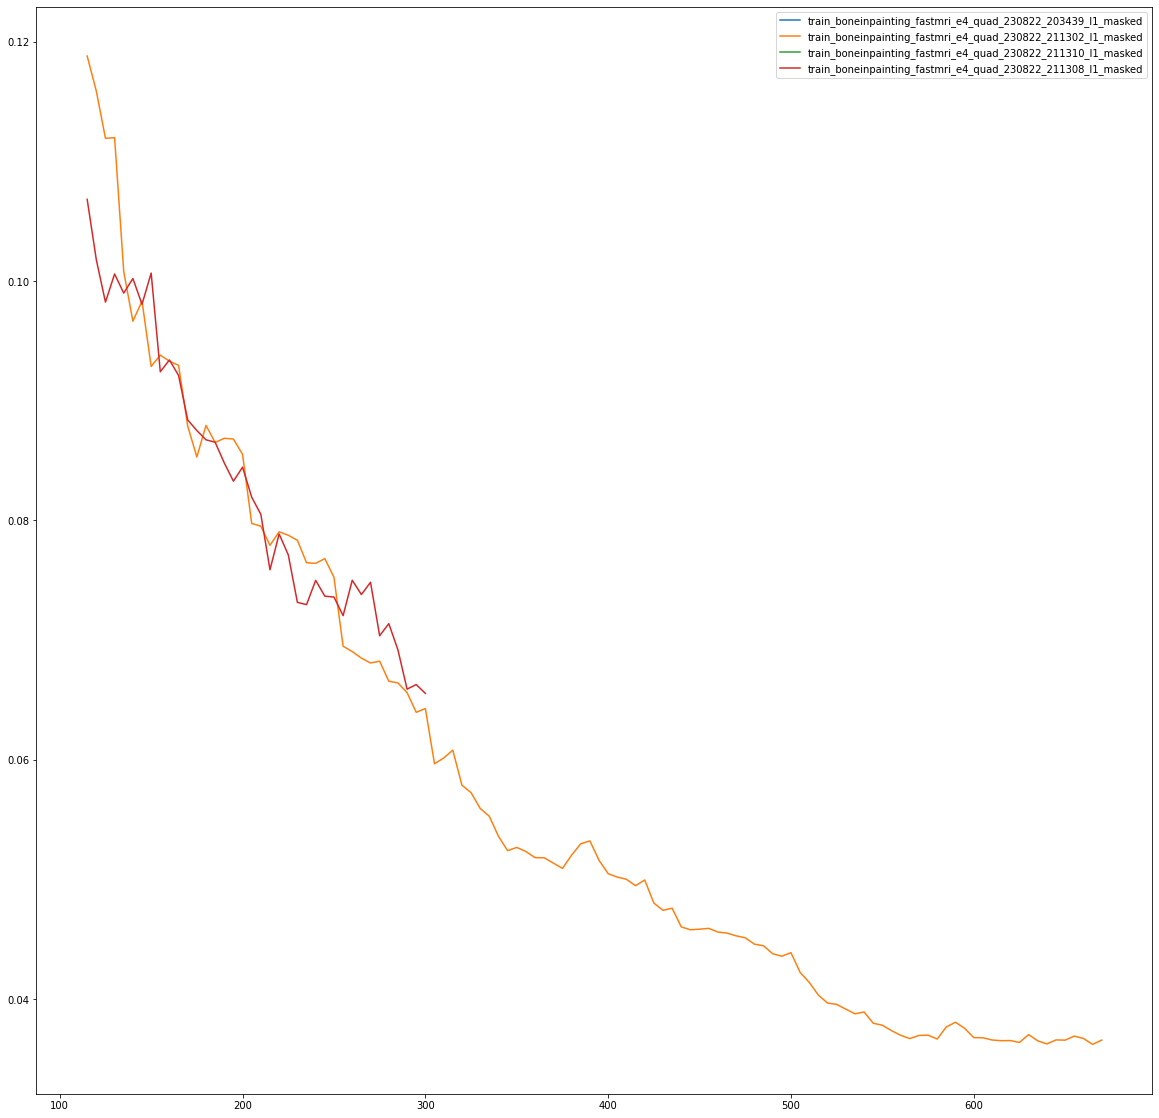

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*boneinpainting*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=1):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out', 'Mask'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','').replace('Mask_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0],
            'mask': [p for p in pngs if k in p and 'Mask' in p][0]} for k in slcs}
        loss = {
            # 'kl': [],
            # 'ce': [],
            # 'l1': [],
            # 'k2': [],
            'l1_masked': []
        }
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            mask_path = slc['mask']
            mask = Image.open(mask_path)
            mask_array = tx(mask) == 1
            # loss['kl'].append(kl(out_array, gt_array))
            # loss['ce'].append(ce(out_array, gt_array))
            # loss['l1'].append(ce(out_array, gt_array))
            # loss['k2'].append(ce(out_array, gt_array))
            loss['l1_masked'].append(torch.sum(torch.abs(gt_array - out_array)) / mask_array.sum())
        ret[epoch] = {
            # 'kl': torch.tensor(loss['kl']).mean(),
            # 'ce': torch.tensor(loss['ce']).mean(),
            # 'l1': torch.tensor(loss['l1']).mean(),
            # 'k2': torch.tensor(loss['k2']).mean(),
            'l1_masked': torch.tensor(loss['l1_masked']).mean(),
        }
        # print(experiment, epoch, end='\r')

    if [r['l1_masked'] for r in ret.values()]:
        for lname in loss:
            ax.plot(ret.keys(), pd.Series([r[lname] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=f'{experiment}_{lname}')
ax.legend()
plt.show()